## Building MultiModal Search with Vector Databases 

This notebook demonstrates how build multi-modal search (image, audio, video) `Meta AI ImageBind` model ([multi2vec-bind](https://weaviate.io/developers/weaviate/modules/retriever-vectorizer-modules/multi2vec-bind)).

ImageBind allows us to search through text, images, audio and video files.

This recipe will focus on searching through image, audio and video:

* [text-to-media search](#text-to-media-search) - provide text as input to search through media
* [image-to-media search](#image-to-media-search) - provide image as input to search through media
* [audio-to-media search](#audio-to-media-search) - provide audio as input to search through media
* [video-to-media search](#video-to-media-search) - provide video as input to search through media

### Start Weaviate Multi-Vector Store

```bash
docker compose -f weaviate-docker-compose up -d
```

### Dependencies

    1. The Weaviate Python Client

In [ ]:
%pip install -U "weaviate-client==4.4.1"

### Connect to Weaviate

In [2]:
import weaviate, os

client = weaviate.connect_to_local()

client.is_ready()

True

In [3]:
client.get_meta()

{'hostname': 'http://[::]:8080',
 'modules': {'multi2vec-bind': {'model': 'ImageBindModel', 'version': 1}},
 'version': '1.23.7'}

## Create the index

In [4]:
import weaviate.classes as wvc

if (client.collections.exists("index")):
    client.collections.delete("index")

client.collections.create(
    name="index",
    vectorizer_config=wvc.config.Configure.Vectorizer.multi2vec_bind(
        audio_fields=["audio"],
        image_fields=["image"],
        video_fields=["video"],
    )
)

In [5]:
import base64

# Helper function to convert a file to base64 representation
def toBase64(path):
    with open(path, 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')


### Insert Images into Weaviate

In [6]:
index = client.collections.get("index")

source = os.listdir("./data/weaviate/image/")
items = list()

for name in source:
    print(f"Adding {name}")
    
    path = "./data/weaviate/image/" + name
    
    items.append({
        "name": name,            # name of the file
        "path": path,            # path to the file to display result
        "image": toBase64(path), # this gets vectorized - "image" was configured in vectorizer_config as the property holding images
        "mediaType": "image",    # a label telling us how to display the resource 
    })

    # import images in batches of 5
    if (len(items) == 5):
        print(f"Inserting {len(items)} image objects into the vector store.")
        index.data.insert_many(items)
        items.clear()

# Insert any remaining items
if (len(items) > 0):
    print(f"Inserting {len(items)} image objects.")
    index.data.insert_many(items)

Adding dog3.jpg
Adding dog2.jpg
Adding dog1.jpg
Adding cat1.jpg
Adding cat2.jpg
Inserting 5 image objects into the vector store.
Adding cat3.jpg
Adding meerkat3.jpg
Adding meerkat2.jpg
Adding meerkat1.jpg
Inserting 4 image objects.


In [7]:
#Object count
index = client.collections.get("index")
index.aggregate.over_all()

AggregateReturn(properties={}, total_count=9)

### Insert Audio Files into Weaviate

In [8]:
index = client.collections.get("index")

source = os.listdir("./data/weaviate/audio/")
items = list()

for name in source:
    print(f"Adding {name}")
    
    path = "./data/weaviate/audio/" + name
    items.append({
        "name": name,
        "path": path,
        "audio": toBase64(path),
        "mediaType": "audio"
    })

    # import images in batches of 3
    if(len(items) == 3):
        print(f"Inserting {len(items)} audio objects.")
        index.data.insert_many(items)
        items.clear()

# Insert any remaining items
if (len(items) > 0):
    print(f"Inserting {len(items)} audio objects.")
    index.data.insert_many(items)

Adding mixkit-little-birds-singing-in-the-trees-17.wav
Adding mixkit-jungle-ape-sound-2419.wav
Adding mixkit-rooster-crowing-in-the-morning-2462.wav
Inserting 3 audio objects.
Adding mixkit-dog-barking-twice-1.wav
Adding mixkit-cow-moo-1744.wav
Adding mixkit-cartoon-kitty-begging-meow-92.wav
Inserting 3 audio objects.


In [9]:
index.aggregate.over_all()

AggregateReturn(properties={}, total_count=15)

### Insert Video Files into Weaviate

In [10]:
index = client.collections.get("index")

source = os.listdir("./data/weaviate/video/")

for name in source:    
    path = "./data/weaviate/video/" + name
    item = {
        "name": name,
        "path": path,
        "video": toBase64(path),
        "mediaType": "video"
    }
    
    # insert videos one by one
    index.data.insert(item)

    print(f"Inserting 1 video object into the vector store.")    

Inserting 1 video object into the vector store.
Inserting 1 video object into the vector store.
Inserting 1 video object into the vector store.
Inserting 1 video object into the vector store.
Inserting 1 video object into the vector store.
Inserting 1 video object into the vector store.


In [11]:
index.aggregate.over_all()

AggregateReturn(properties={}, total_count=21)

In [12]:
agg = index.aggregate.over_all(
    group_by="mediaType"
)

for group in agg.groups:
    print(group)


AggregateGroup(grouped_by=GroupedBy(prop='mediaType', value='image'), properties={}, total_count=9)
AggregateGroup(grouped_by=GroupedBy(prop='mediaType', value='audio'), properties={}, total_count=6)
AggregateGroup(grouped_by=GroupedBy(prop='mediaType', value='video'), properties={}, total_count=6)


### Check all the media files added to the Vector Database

In [13]:
itr = index.iterator(
    return_properties=["name", "mediaType"],
    # include_vector=True, # in case you want to see the vectors
)

for item in itr:
    print(item.properties)

{'mediaType': 'image', 'name': 'meerkat3.jpg'}
{'mediaType': 'video', 'name': 'cat-clean.mp4'}
{'mediaType': 'audio', 'name': 'mixkit-cow-moo-1744.wav'}
{'mediaType': 'video', 'name': 'meerkat-dig.mp4'}
{'mediaType': 'video', 'name': 'meerkat-watch.mp4'}
{'mediaType': 'image', 'name': 'dog2.jpg'}
{'mediaType': 'image', 'name': 'meerkat2.jpg'}
{'mediaType': 'image', 'name': 'cat3.jpg'}
{'mediaType': 'video', 'name': 'dog-with-stick.mp4'}
{'mediaType': 'audio', 'name': 'mixkit-rooster-crowing-in-the-morning-2462.wav'}
{'mediaType': 'image', 'name': 'cat1.jpg'}
{'mediaType': 'image', 'name': 'meerkat1.jpg'}
{'mediaType': 'audio', 'name': 'mixkit-little-birds-singing-in-the-trees-17.wav'}
{'mediaType': 'image', 'name': 'dog1.jpg'}
{'mediaType': 'video', 'name': 'cat-play.mp4'}
{'mediaType': 'video', 'name': 'dog-high-five.mp4'}
{'mediaType': 'audio', 'name': 'mixkit-cartoon-kitty-begging-meow-92.wav'}
{'mediaType': 'audio', 'name': 'mixkit-jungle-ape-sound-2419.wav'}
{'mediaType': 'audio',

# Any-to-Any Multimodal Search

In [14]:
# Helper functions to display results
import json
from IPython.display import Image, Audio, Video
import base64, requests

def json_print(data):
    print(json.dumps(data, indent=2))

def display_media(item):
    path = item["path"]

    if(item["mediaType"] == "image"):
        display(Image(path))

    elif(item["mediaType"] == "video"):
        display(Video(path))
        
    elif(item["mediaType"] == "audio"):
        display(Audio(path))

# Helper function – get base64 representation from an online image
def url_to_base64(url):
    image_response = requests.get(url)
    content = image_response.content
    return base64.b64encode(content).decode('utf-8')

# Helper function - get base64 representation from a local file
def file_to_base64(path):
    with open(path, 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

# Update the url and path to test
#test_image_base64 = url_to_base64("https://path-to-some-online-image.jpg")
#test_file_base64 = file_to_base64("./test/meerkat.jpeg")

<a id='text-to-media-search'></a>
### Text to Any Search

{
  "mediaType": "video",
  "path": "./data/weaviate/video/dog-with-stick.mp4",
  "name": "dog-with-stick.mp4"
}


{
  "mediaType": "audio",
  "path": "./data/weaviate/audio/mixkit-dog-barking-twice-1.wav",
  "name": "mixkit-dog-barking-twice-1.wav"
}


{
  "mediaType": "image",
  "path": "./data/weaviate/image/dog3.jpg",
  "name": "dog3.jpg"
}


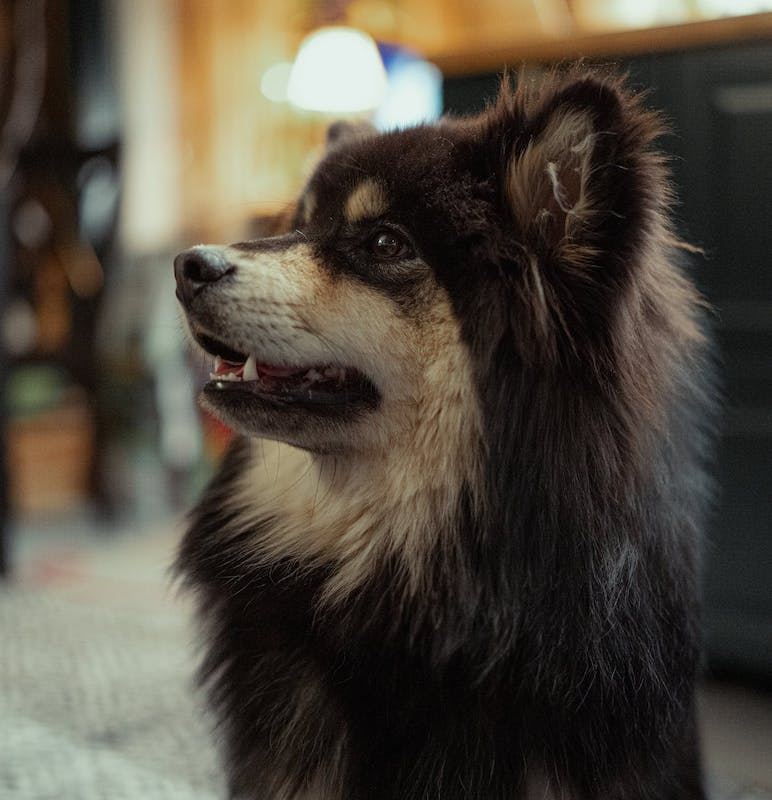

{
  "mediaType": "video",
  "path": "./data/weaviate/video/dog-high-five.mp4",
  "name": "dog-high-five.mp4"
}


{
  "mediaType": "image",
  "path": "./data/weaviate/image/dog2.jpg",
  "name": "dog2.jpg"
}


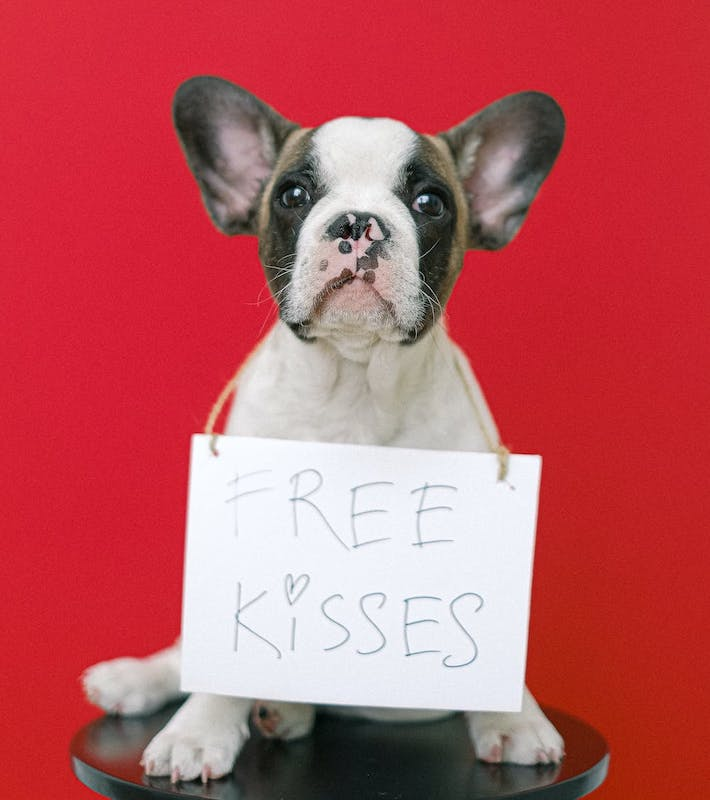

In [15]:
response = index.query.near_text(
    query="dog with stick",
    return_properties=['name','path','mediaType'],
    limit=5
)

for obj in response.objects:
    json_print(obj.properties)
    display_media(obj.properties)

<a id='image-to-media-search'></a>
### Image to Any Search

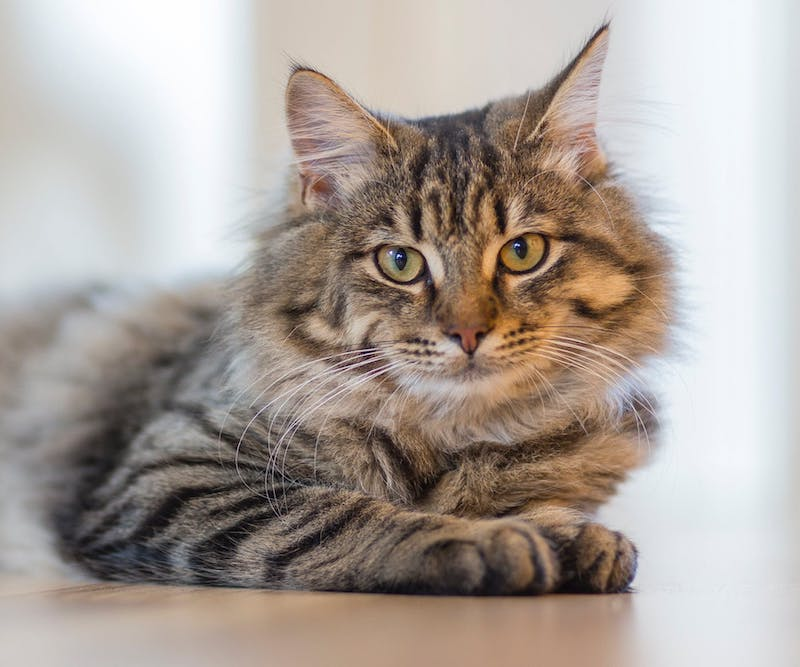

In [16]:
Image("./data/weaviate/test-cat.jpg")

{
  "mediaType": "image",
  "path": "./data/weaviate/image/cat1.jpg",
  "name": "cat1.jpg"
}


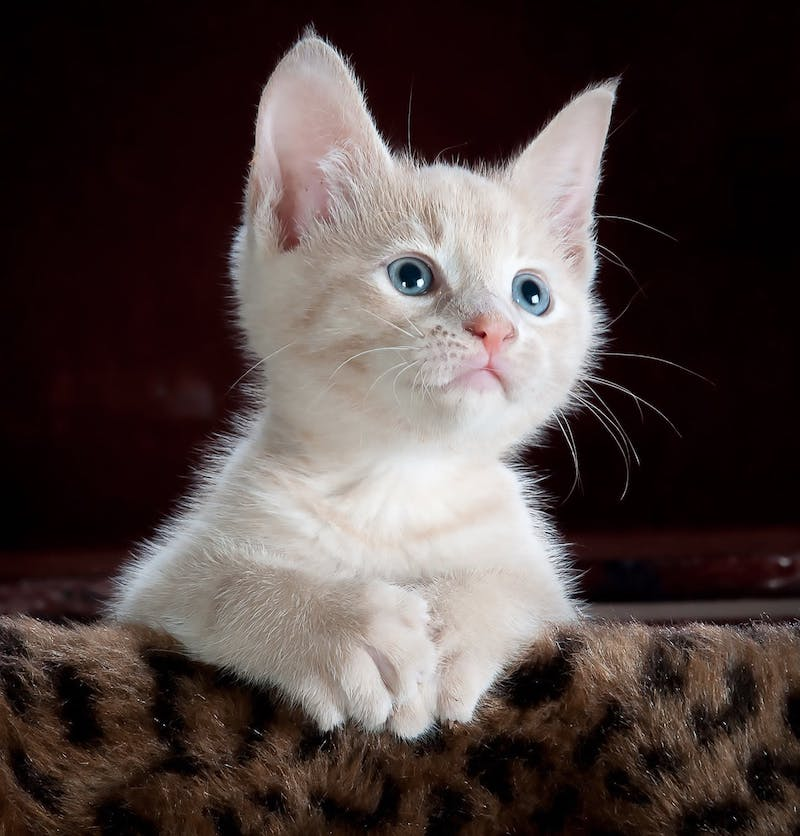

{
  "mediaType": "image",
  "path": "./data/weaviate/image/cat2.jpg",
  "name": "cat2.jpg"
}


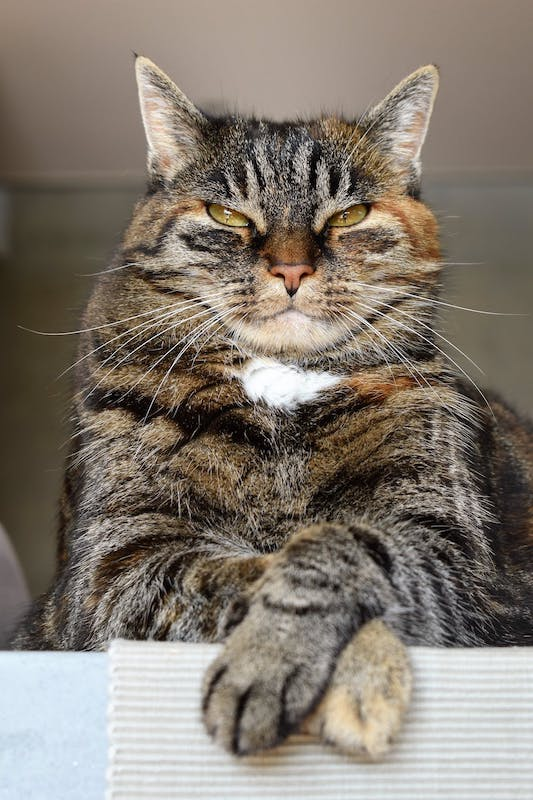

{
  "mediaType": "image",
  "path": "./data/weaviate/image/cat3.jpg",
  "name": "cat3.jpg"
}


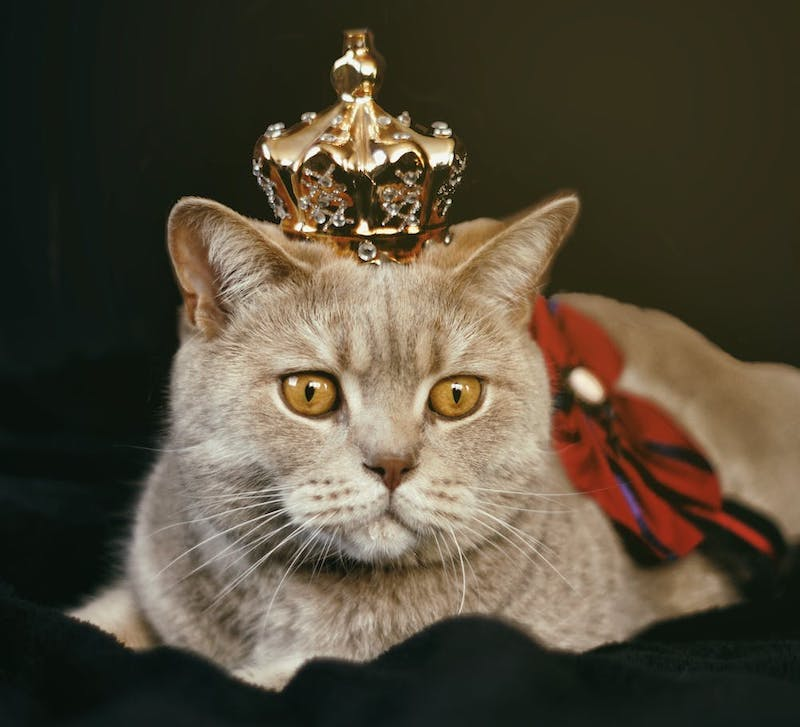

In [17]:
response = index.query.near_image(
    near_image=toBase64("./data/weaviate/test-cat.jpg"),
    return_properties=['name','path','mediaType'],
    limit=3
)

for obj in response.objects:
    json_print(obj.properties)
    display_media(obj.properties)

<a id='audio-to-media-search'></a>
### Audio to Any Search

In [18]:
Audio("./data/weaviate/dog_audio.wav")

{
  "mediaType": "audio",
  "path": "./data/weaviate/audio/mixkit-dog-barking-twice-1.wav",
  "name": "mixkit-dog-barking-twice-1.wav"
}


{
  "mediaType": "video",
  "path": "./data/weaviate/video/dog-with-stick.mp4",
  "name": "dog-with-stick.mp4"
}


{
  "mediaType": "image",
  "path": "./data/weaviate/image/dog3.jpg",
  "name": "dog3.jpg"
}


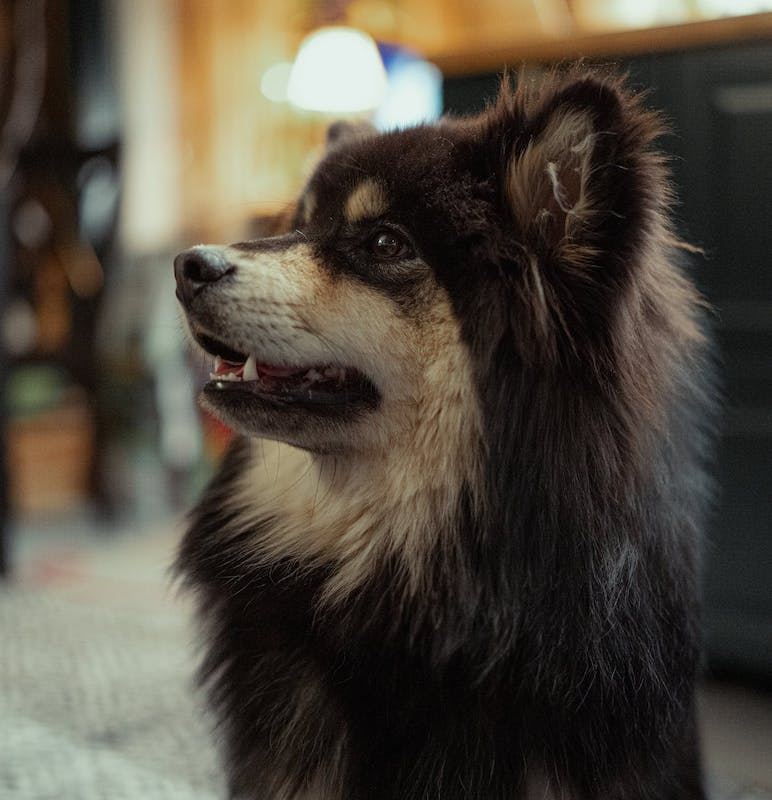

In [19]:
import weaviate.classes.query as wq

response = index.query.near_media(
    media=toBase64("./data/weaviate/dog_audio.wav"),
    media_type=wq.NearMediaType.AUDIO,
    return_properties=['name','path','mediaType'],
    limit=3
)

for obj in response.objects:
    json_print(obj.properties)
    display_media(obj.properties)

<a id='video-to-media-search'></a>
### Video to Any Search

In [20]:
Video("./data/weaviate/test-meerkat.mp4")

{
  "mediaType": "video",
  "path": "./data/weaviate/video/meerkat-watch.mp4",
  "name": "meerkat-watch.mp4"
}


{
  "mediaType": "image",
  "path": "./data/weaviate/image/meerkat3.jpg",
  "name": "meerkat3.jpg"
}


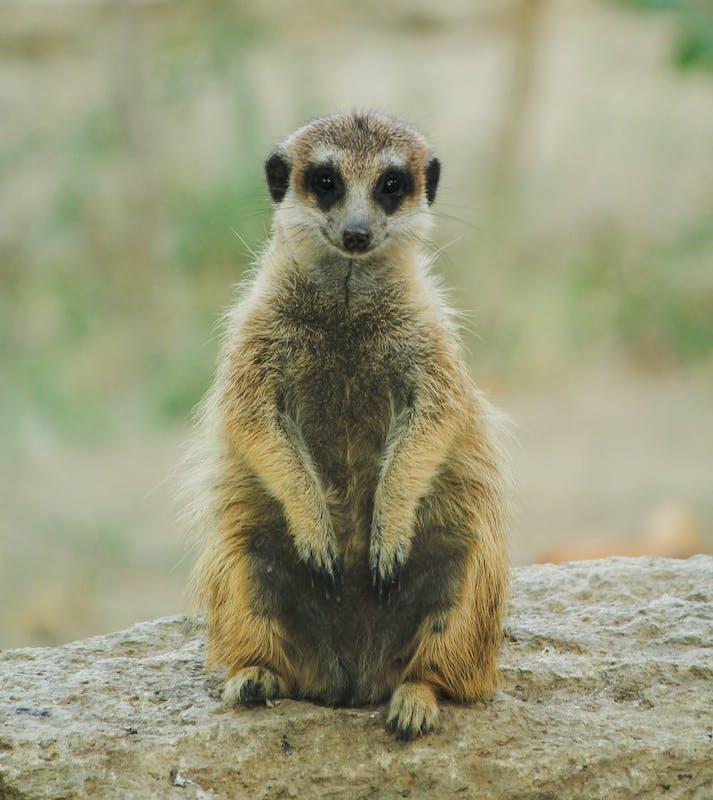

{
  "mediaType": "image",
  "path": "./data/weaviate/image/meerkat2.jpg",
  "name": "meerkat2.jpg"
}


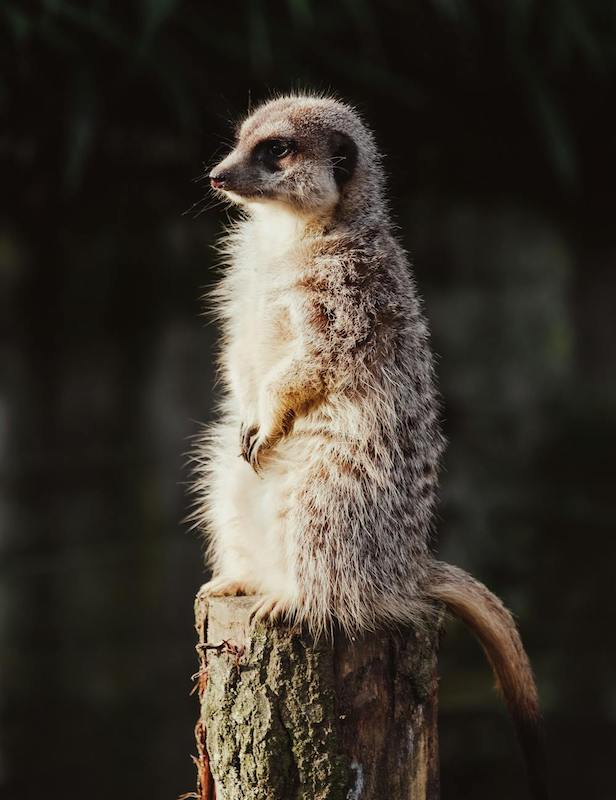

In [21]:
response = index.query.near_media(
    media=toBase64("./data/weaviate/test-meerkat.mp4"),
    media_type=wq.NearMediaType.VIDEO,
    return_properties=['name','path','mediaType'],
    limit=3
)

for obj in response.objects:
    json_print(obj.properties)
    display_media(obj.properties)